# Train ML Methods
- Environment setup
- Load datasets
- Extract features by random forest (feature importance)
- Prepare data: generate data only contains selected features
- Train-Test split / data normalisation
- Save 2017 upstream data as scratch - used for retraining for the new data
- Train model
- Tune hyperparameter

### Environment setup

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!wget https://downloads.rclone.org/v1.63.0/rclone-v1.63.0-linux-amd64.deb
!apt install ./rclone-v1.63.0-linux-amd64.deb
!rclone config
!sudo apt-get -y install fuse3

--2023-08-17 09:30:42--  https://downloads.rclone.org/v1.63.0/rclone-v1.63.0-linux-amd64.deb
Resolving downloads.rclone.org (downloads.rclone.org)... 95.217.6.16, 2a01:4f9:c012:7154::1
Connecting to downloads.rclone.org (downloads.rclone.org)|95.217.6.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18373062 (18M) [application/vnd.debian.binary-package]
Saving to: ‘rclone-v1.63.0-linux-amd64.deb’

rclone-v1.63.0-linu 100%[===================>]  17.52M  12.0MB/s    in 1.5s    

2023-08-17 09:30:44 (12.0 MB/s) - ‘rclone-v1.63.0-linux-amd64.deb’ saved [18373062/18373062]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'rclone' instead of './rclone-v1.63.0-linux-amd64.deb'
The following NEW packages will be installed:
  rclone
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 0 B/18.4 MB of archives.
After this operation, 56.7 MB of additional disk space will be used.
Get

In [3]:
!sudo mkdir /content/onedrive
!nohup rclone --vfs-cache-mode writes mount onedrive: /content/onedrive &

nohup: appending output to 'nohup.out'


### Load datasets

In [4]:
# Import Necessary Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score # performance metrics

import time
import joblib

In [5]:
pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00


In [6]:
data2017_original = pd.read_parquet('/content/onedrive/data_2017_original.parquet', engine="fastparquet")
# data2017_corrected = pd.read_parquet('/content/onedrive/data_2017_corrected.parquet', engine="fastparquet")
# data2018_original = pd.read_parquet('/content/onedrive/data_2018_original.parquet', engine="fastparquet")
# data2018_corrected = pd.read_parquet('/content/onedrive/data_2018_corrected_sampling.parquet', engine="fastparquet")

In [ ]:
# data2017_original_resampling = pd.read_parquet('/content/onedrive/data_2017_original_resampling.parquet', engine="fastparquet")
# data2017_corrected_resampling = pd.read_parquet('/content/onedrive/data_2017_corrected_resampling.parquet', engine="fastparquet")
# data2018_original_resampling = pd.read_parquet('/content/onedrive/data_2018_original_resampling.parquet', engine="fastparquet")
data2018_corrected_resampling = pd.read_parquet('/content/onedrive/data_2018_corrected_sampling_resampling.parquet', engine="fastparquet")

### Extract Features - RandomForest

In [ ]:
def train_rf(data):
    X_train, X_test, y_train, y_test = split_data(data)
    X_train, X_test = normalise_data(X_train, X_test)
    forest = RandomForestClassifier(random_state=42)
    start_time = time.time()
    # Train the model on the training data
    forest.fit(X_train, y_train)
    end_time = time.time()
    time_taken = end_time - start_time
    print("Time taken to fit the model:", time_taken, "seconds")
    return forest

Get fearure scores from 2017 original dataset

In [ ]:
forest = train_rf(data2017_original)
feature_scores = (pd.Series(forest.feature_importances_, index=data2017_original.columns[0:len(data2017_original.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores}')

Number of rows of train data: 2017607
Number of columns of train data: 76
Number of rows of test data: 504402
Number of columns of test data: 76
Time taken to fit the model: 926.2445492744446 seconds
feature_scores: Packet Length Std         0.077944
Bwd Packet Length Std     0.075532
Packet Length Variance    0.075460
Bwd Packet Length Mean    0.069707
Average Packet Size       0.051550
                            ...   
Bwd Avg Packets/Bulk      0.000000
Bwd Avg Bytes/Bulk        0.000000
Fwd Avg Bulk Rate         0.000000
Fwd Avg Packets/Bulk      0.000000
Fwd Avg Bytes/Bulk        0.000000
Length: 76, dtype: float64


In [ ]:
feature_scores.to_csv('features_scores.csv', )

Get fearure scores from 2017 improved dataset

In [ ]:
forest = train_rf(data2017_corrected)
feature_scores = (pd.Series(forest.feature_importances_, index=data2017_corrected.columns[0:len(data2017_corrected.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores}')

Number of rows of train data: 1679976
Number of columns of train data: 81
Number of rows of test data: 419995
Number of columns of test data: 81
Time taken to fit the model: 1102.3750538825989 seconds
feature_scores: RST Flag Count                 7.425164e-02
Total Length of Fwd Packets    6.608519e-02
Bwd Packet Length Std          6.065193e-02
Fwd Packet Length Mean         5.300097e-02
Fwd Packet Length Max          4.810393e-02
                                   ...     
Fwd URG Flags                  5.569828e-06
Subflow Bwd Packets            3.217053e-06
ECE Flag Count                 1.057672e-06
CWE Flag Count                 1.040469e-06
Bwd URG Flags                  3.110745e-08
Length: 81, dtype: float64


In [ ]:
feature_scores.to_csv('features_scores_2017_improved.csv', )

Get fearure scores from 2018 original dataset

In [ ]:
forest = train_rf(data2018_original)
feature_scores = (pd.Series(forest.feature_importances_, index=data2018_original.columns[0:len(data2018_original.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores}')

Number of rows of train data: 8655235
Number of columns of train data: 76
Number of rows of test data: 2163809
Number of columns of test data: 76
Time taken to fit the model: 9496.710687160492 seconds
feature_scores: Init_Win_bytes_forward         0.054198
Subflow Fwd Bytes              0.039838
Avg Fwd Segment Size           0.038505
Total Length of Fwd Packets    0.037506
Fwd Packet Length Mean         0.033570
                                 ...   
Fwd Avg Bulk Rate              0.000000
Fwd Avg Packets/Bulk           0.000000
Fwd Avg Bytes/Bulk             0.000000
Bwd URG Flags                  0.000000
Bwd Avg Bulk Rate              0.000000
Length: 76, dtype: float64


In [ ]:
feature_scores.to_csv('features_scores_2018_original.csv', )


Get fearure scores from 2018 improved dataset

In [ ]:
forest = train_rf(data2018_corrected)
feature_scores = (pd.Series(forest.feature_importances_, index=data2018_corrected.columns[0:len(data2018_corrected.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores}')

Number of rows of train data: 7821600
Number of columns of train data: 81
Number of rows of test data: 1955400
Number of columns of test data: 81
Time taken to fit the model: 4503.075605869293 seconds
feature_scores: Init_Win_bytes_forward     0.127610
Init_Win_bytes_backward    0.075568
Flow IAT Min               0.066941
min_seg_size_forward       0.050548
Max Packet Length          0.049419
                             ...   
Active Std                 0.000012
Bwd Avg Bytes/Bulk         0.000006
Bwd Avg Bulk Rate          0.000003
Subflow Bwd Packets        0.000001
Bwd URG Flags              0.000000
Length: 81, dtype: float64


In [ ]:
feature_scores.to_csv('features_scores_2018_improved.csv', )

Get fearure scores from 2017 original resampling dataset

In [ ]:
forest_resampling = train_rf(data2017_original_resampling)
feature_scores_resampling = (pd.Series(forest_resampling.feature_importances_, index=data2017_original_resampling.columns[0:len(data2017_original_resampling.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores_resampling}')

NameError: name 'split_data' is not defined

In [ ]:
feature_scores_resampling.to_csv('feature_scores_resampling.csv')

NameError: name 'feature_scores_resampling' is not defined

Get fearure scores from 2017 improved resampling dataset

In [ ]:
forest_resampling = train_rf(data2017_corrected_resampling)
feature_scores_resampling = (pd.Series(forest_resampling.feature_importances_, index=data2017_corrected_resampling.columns[0:len(data2017_corrected_resampling.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores_resampling}')

Number of rows of train data: 827856
Number of columns of train data: 82
Number of rows of test data: 206964
Number of columns of test data: 82
Time taken to fit the model: 314.42701029777527 seconds
feature_scores: RST Flag Count            8.828929e-02
SYN Flag Count            6.177930e-02
Bwd Packet Length Min     5.028303e-02
Init_Win_bytes_forward    4.937932e-02
PSH Flag Count            4.009322e-02
                              ...     
Fwd URG Flags             1.308421e-05
ECE Flag Count            2.050835e-06
Subflow Bwd Packets       4.793547e-07
CWE Flag Count            9.613972e-08
Bwd URG Flags             0.000000e+00
Length: 82, dtype: float64


In [ ]:
feature_scores_resampling.to_csv('feature_scores_resampling_2017_improved.csv')

Get fearure scores from 2018 original resampling dataset

In [ ]:
forest_resampling = train_rf(data2018_original_resampling)
feature_scores_resampling = (pd.Series(forest_resampling.feature_importances_, index=data2018_original_resampling.columns[0:len(data2018_original_resampling.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores_resampling}')

Number of rows of train data: 2121352
Number of columns of train data: 76
Number of rows of test data: 530338
Number of columns of test data: 76
Time taken to fit the model: 1465.0386879444122 seconds
feature_scores: Init_Win_bytes_forward     0.050379
Subflow Fwd Bytes          0.048041
Init_Win_bytes_backward    0.044627
Fwd Header Length          0.038640
Flow IAT Mean              0.032487
                             ...   
Fwd Avg Packets/Bulk       0.000000
Bwd Avg Packets/Bulk       0.000000
Fwd Avg Bulk Rate          0.000000
Bwd Avg Bytes/Bulk         0.000000
Bwd PSH Flags              0.000000
Length: 76, dtype: float64


In [ ]:
feature_scores_resampling.to_csv('feature_scores_resampling_2018_original.csv')

Get fearure scores from 2018 improved resampling dataset

In [ ]:
forest_resampling = train_rf(data2018_corrected_resampling)
feature_scores_resampling = (pd.Series(forest_resampling.feature_importances_, index=data2018_corrected_resampling.columns[0:len(data2018_corrected_resampling.columns)-1]).sort_values(ascending=False))
print(f'feature_scores: {feature_scores_resampling}')

Number of rows of train data: 6146650
Number of columns of train data: 81
Number of rows of test data: 1536663
Number of columns of test data: 81
------------------------------------------
train - benign: 3072997; attack: 3073653
test - benign: 768657; attack: 768006
Time taken to fit the model: 7989.747261285782 seconds
feature_scores: Init_Win_bytes_forward     1.293166e-01
Flow IAT Min               7.679823e-02
Init_Win_bytes_backward    6.864604e-02
FIN Flag Count             5.791972e-02
Max Packet Length          4.783943e-02
                               ...     
Bwd Avg Packets/Bulk       2.619450e-05
Bwd Avg Bulk Rate          1.890541e-05
Bwd Avg Bytes/Bulk         1.437871e-05
Subflow Bwd Packets        3.268399e-07
Bwd URG Flags              0.000000e+00
Length: 81, dtype: float64


In [ ]:
feature_scores_resampling.to_csv('/content/onedrive/feature_scores_resampling_2018_improved.csv')

### Get feature scores

In [28]:
feature_scores = pd.read_csv('/content/onedrive/features_scores.csv', names=['feature', 'importance ratio'], header=0)

In [29]:
feature_extract_item = list(feature_scores[feature_scores['importance ratio'] > 0.03]['feature'])
feature_extract_item.append('label_encoded')
feature_extract_item

['Packet Length Std',
 'Bwd Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Mean',
 'Average Packet Size',
 'Bwd Packet Length Max',
 'Avg Bwd Segment Size',
 'Packet Length Mean',
 'Max Packet Length',
 'Subflow Bwd Bytes',
 'label_encoded']

In [ ]:
feature_scores_resampling = pd.read_csv('/content/onedrive/feature_scores_resampling.csv', names=['feature', 'importance ratio'], header = 0)

In [ ]:
feature_resampling_extract_item = list(feature_scores_resampling[feature_scores_resampling['importance ratio'] > 0.03]['feature'])
feature_resampling_extract_item.append('label_encoded')
feature_resampling_extract_item

['Average Packet Size',
 'Packet Length Variance',
 'Bwd Packet Length Std',
 'Packet Length Std',
 'Bwd Packet Length Max',
 'Packet Length Mean',
 'Bwd Packet Length Mean',
 'Max Packet Length',
 'Avg Bwd Segment Size',
 'Avg Fwd Segment Size',
 'Init_Win_bytes_backward',
 'label_encoded']

### Prepare data: generate data only contains selected features

In [ ]:
data2017_original = data2017_original[feature_extract_item]

In [ ]:
data2017_original_resampling = data2017_original_resampling[feature_resampling_extract_item]

In [ ]:
data2017_corrected = data2017_corrected[feature_extract_item]

In [ ]:
data2017_corrected_resampling = data2017_corrected_resampling[feature_resampling_extract_item]

In [ ]:
data2018_original = data2018_original[feature_extract_item]

In [ ]:
data2018_original_resampling = data2018_original_resampling[feature_resampling_extract_item]

In [ ]:
data2018_corrected = data2018_corrected[feature_extract_item]

In [ ]:
data2018_corrected_resampling = data2018_corrected_resampling[feature_resampling_extract_item]

### Train-Test split / data normalisation

In [9]:
def split_data(data):
    X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'label_encoded'], data['label_encoded'], test_size=0.2, random_state=42) #reproducible

    num_rows, num_cols = X_train.shape
    print(f"Number of rows of train data: {num_rows}")
    print(f"Number of columns of train data: {num_cols}")

    num_rows, num_cols = X_test.shape
    print(f"Number of rows of test data: {num_rows}")
    print(f"Number of columns of test data: {num_cols}")

    print("------------------------------------------")
    print(f"train - benign: {y_train[y_train == 0].shape[0]}; attack: {y_train[y_train == 1].shape[0]}")
    print(f"test - benign: {y_test[y_test == 0].shape[0]}; attack: {y_test[y_test == 1].shape[0]}")

    return X_train, X_test, y_train, y_test

In [10]:
def normalise_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2017_original)

data_test_2017_original = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 2016638
Number of columns of train data: 10
Number of rows of test data: 504160
Number of columns of test data: 10
------------------------------------------
train - benign: 1676159; attack: 340479
test - benign: 418898; attack: 85262


In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2017_original_resampling)

data_test_2017_original_resample = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 681185
Number of columns of train data: 11
Number of rows of test data: 170297
Number of columns of test data: 11
------------------------------------------
train - benign: 340605; attack: 340580
test - benign: 85136; attack: 85161


### Save 2017 upstream data as scratch - used for retraining for the new data

In [ ]:
X_train = pd.DataFrame(X_train, columns = feature_extract_item[0:10])
y_train = y_train.reset_index(drop=True)

X_train_r = pd.DataFrame(X_train_r, columns = feature_resampling_extract_item[0:11])
y_train_r = y_train_r.reset_index(drop=True)

In [ ]:
upstream_model_data = pd.concat([X_train, y_train], axis = 1)
upstream_model_data = pd.concat([X_train_r, y_train_r], axis = 1)

In [ ]:
upstream_model_data

,Average Packet Size,Packet Length Variance,Bwd Packet Length Std,Packet Length Std,Bwd Packet Length Max,Packet Length Mean,Bwd Packet Length Mean,Max Packet Length,Avg Bwd Segment Size,Avg Fwd Segment Size,Init_Win_bytes_backward,label_encoded
0,1.128662,0.523994,0.988909,1.039205,1.233551,1.168024,1.365209,1.208958,1.365209,-0.009937,-0.175099,1
1,-0.619454,-0.510594,-0.636201,-0.690914,-0.660844,-0.655886,-0.678032,-0.675788,-0.678032,-0.017232,-0.208157,0
2,1.776607,0.705177,0.988909,1.184592,1.233551,1.773826,1.365209,1.208958,1.365209,0.834867,-0.175099,1
3,-0.755770,-0.510591,-0.636201,-0.688129,-0.676675,-0.753792,-0.730075,-0.689569,-0.730075,-0.285308,-0.071861,0
4,2.233626,1.148491,1.179528,1.500007,1.249381,2.163176,1.785567,1.224708,1.785567,-0.268288,-0.175939,1
...,...,...,...,...,...,...,...,...,...,...,...,...
681180,-0.621519,-0.510231,-0.636201,-0.658511,-0.646662,-0.635943,-0.631410,-0.661679,-0.631410,-0.106591,-0.208157,0
681181,-0.588990,-0.510243,-0.636201,-0.659079,-0.642705,-0.607387,-0.618399,-0.657741,-0.618399,-0.023615,-0.208157,0
681182,-0.557492,-0.509790,-0.621448,-0.642680,-0.628853,-0.579738,-0.588041,-0.643960,-0.588041,-0.026806,-0.208157,0
681183,1.702046,0.729994,0.988909,1.203636,1.233551,1.699449,1.365209,1.208958,1.365209,0.258823,-0.175099,1


In [ ]:
upstream_model_data.to_parquet('/content/onedrive/models/upstream_model_data.parquet', compression=None, engine='fastparquet')
upstream_model_data.to_parquet('/content/onedrive/models/upstream_model_data_resampling.parquet', compression=None, engine='fastparquet')

### Algorithm

In [11]:
# Define constant value
METHOD_RANDOM_FOREST = 'rf'
METHOD_XGBOOST = 'xgb'
METHOD_KNN = 'knn'


In [12]:
methods = [METHOD_RANDOM_FOREST, METHOD_XGBOOST, METHOD_KNN]
# methods = [METHOD_KNN]

### Tune hyperparameter

In [ ]:
clf = RandomForestClassifier()

In [ ]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space4rf = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(3, 10)),
    'max_features': hp.choice('max_features', ["sqrt", "log2", None]),
    'n_estimators': hp.choice('n_estimators', [25, 50, 100, 150]), #how many trees need to be created
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

best = 0

def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=16, trials=trials)
print('best:')
print(best)

new best:
0.968716745930811
{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 100}
new best:
0.9792694573451408
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 150}
100%|██████████| 16/16 [3:07:11<00:00, 701.98s/trial, best loss: -0.9792694573451408]
best:
{'criterion': 1, 'max_depth': 5, 'max_features': 1, 'max_leaf_nodes': 6, 'n_estimators': 3}


0 n_estimators
1 max_depth
2 max_features
3 criterion
4 max_leaf_nodes


<ipython-input-32-29ca5cc73f7f>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[int(i/3), int(i%3)].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))


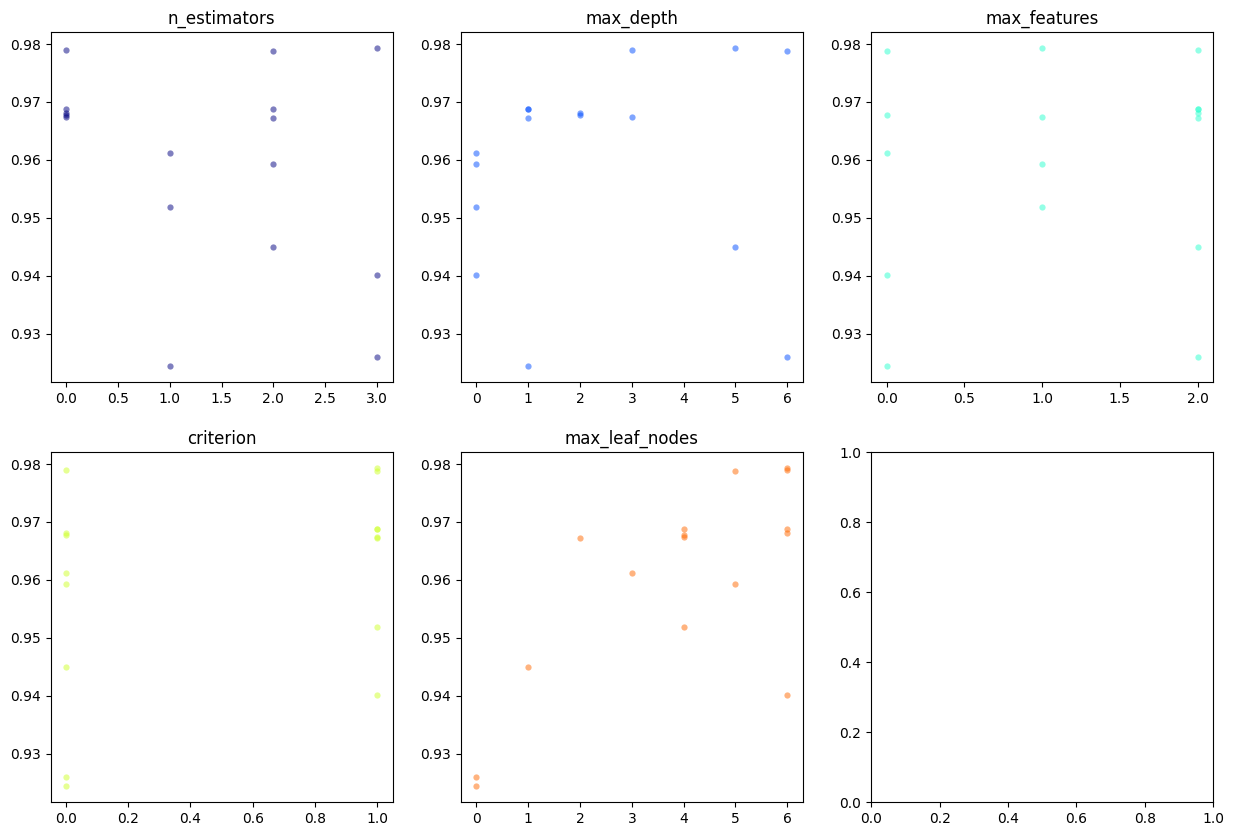

In [ ]:
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion', 'max_leaf_nodes']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print(i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[int(i/3), int(i%3)].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[int(i/3), int(i%3)].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

In [ ]:
def hyperopt_train_test(params):
    clf = xgb.XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space4xgb = {
    'max_depth': hp.choice("max_depth", range(3, 10)),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.choice('n_estimators', [25, 50, 100, 150])
}

best = 0

def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_param_xgb = fmin(f, space4xgb, algo=tpe.suggest, max_evals=16, trials=trials)

print('best:')
print(best_param_xgb)

new best:
0.9883642974258132
{'colsample_bytree': 0.7746641101400913, 'gamma': 5.192938771834221, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 25, 'reg_alpha': 142.0, 'reg_lambda': 0.7690390460784831}
new best:
0.988798683772736
{'colsample_bytree': 0.6793249063243364, 'gamma': 4.30534585392597, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 50, 'reg_alpha': 87.0, 'reg_lambda': 0.15100048946669153}
new best:
0.9891056302716713
{'colsample_bytree': 0.8653986157607052, 'gamma': 4.049853844532946, 'max_depth': 8, 'min_child_weight': 7.0, 'n_estimators': 100, 'reg_alpha': 52.0, 'reg_lambda': 0.9937045075256274}
100%|██████████| 16/16 [42:24<00:00, 159.05s/trial, best loss: -0.9891056302716713]
best:
{'colsample_bytree': 0.8653986157607052, 'gamma': 4.049853844532946, 'max_depth': 5, 'min_child_weight': 7.0, 'n_estimators': 2, 'reg_alpha': 52.0, 'reg_lambda': 0.9937045075256274}


0 max_depth
1 gamma
2 reg_alpha
3 reg_lambda
4 colsample_bytree
5 min_child_weight
6 n_estimators


<ipython-input-36-7ce5535b138d>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[int(i/4), int(i%4)].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))


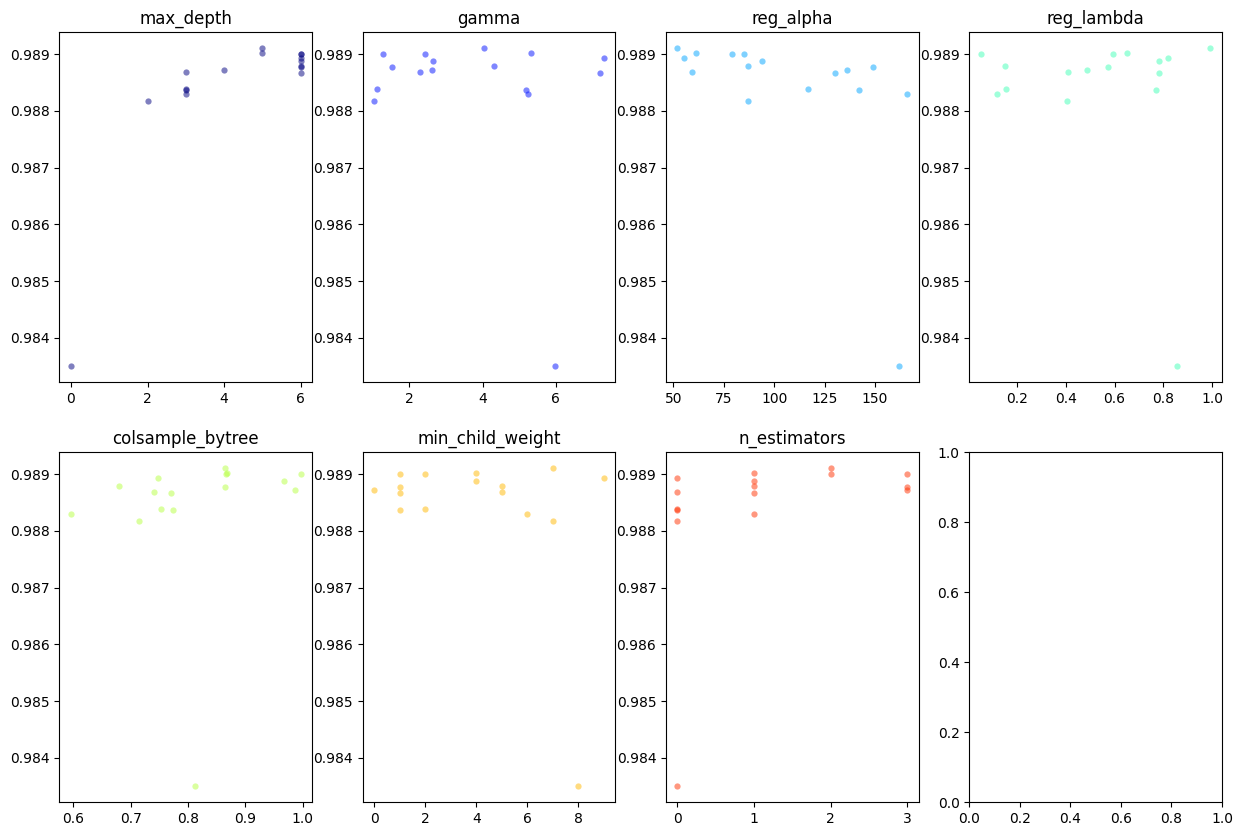

In [ ]:
parameters = ['max_depth', 'gamma', 'reg_alpha', 'reg_lambda', 'colsample_bytree', 'min_child_weight', 'n_estimators']
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print(i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[int(i/4), int(i%4)].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[int(i/4), int(i%4)].set_title(val)

In [ ]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(3,30))
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best_param_knn = fmin(f, space4knn, algo=tpe.suggest, max_evals=16, trials=trials)
print('best:')
print(best_param_knn)

100%|██████████| 16/16 [18:49:47<00:00, 4236.74s/trial, best loss: -0.9893079472842142]
best:
{'n_neighbors': 5}


Text(0, 0.5, 'cross validation accuracy')

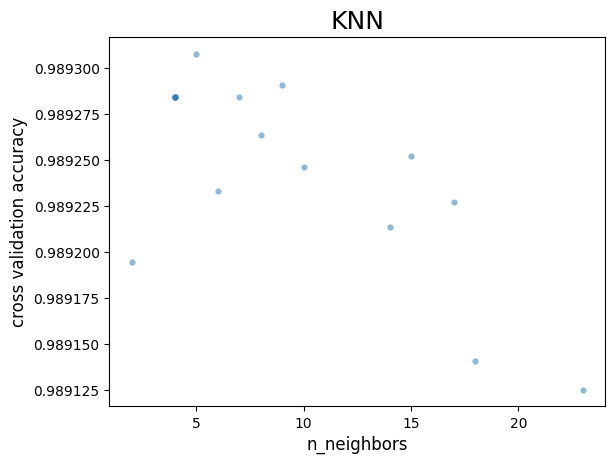

In [ ]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

### Compare and choose the best models across different algorithm

In [ ]:
def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X, y).mean()
space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'scale': hp.choice('scale', [0, 1]),
        'normalize': hp.choice('normalize', [0, 1])
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])
count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print 'new best:', acc, 'using', params['type']
        best = acc
    if count % 50 == 0:
        print 'iters:', count, ', acc:', acc, 'using', params
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1500, trials=trials)
print 'best:'
print best

### Setup optim hyperparameter

In [13]:
best_param_rf = {'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'max_leaf_nodes': 6, 'n_estimators': 3}

In [14]:
best_param_xgb = {'colsample_bytree': 0.8653986157607052, 'gamma': 4.049853844532946, 'max_depth': 5, 'min_child_weight': 7.0, 'n_estimators': 2, 'reg_alpha': 52.0, 'reg_lambda': 0.9937045075256274}

In [15]:
best_param_knn = {'n_neighbors': 5}

### Train Models

In [17]:
def train_rf(X_train, y_train, is_resample, need_save_model):
    print('~~~~START TRAIN RANDOM FOREST~~~~')
    clf = RandomForestClassifier(random_state=42)
    clf.set_params(**best_param_rf)
    start_time = time.time()
    # Train the model on the training data
    clf.fit(X_train, y_train)
    end_time = time.time()
    time_taken = end_time - start_time
    print("Time taken to fit the model:", time_taken, "seconds")
    if (need_save_model):
      if is_resample:
          # joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_RANDOM_FOREST}_resample.joblib")
          joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_RANDOM_FOREST}_resample_finetune_2.joblib")
      else:
          # joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_RANDOM_FOREST}.joblib")
          joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_RANDOM_FOREST}_finetune_2.joblib")
    return clf

In [18]:
def train_xgb(X_train, y_train, is_resample, need_save_model):
    print('~~~~START TRAIN XGBOOST~~~~')
    clf = xgb.XGBClassifier(random_state=42)
    clf.set_params(**best_param_xgb)
    start_time = time.time()
    # Train the model on the training data
    clf.fit(X_train, y_train)
    end_time = time.time()
    time_taken = end_time - start_time
    print("Time taken to fit the model:", time_taken, "seconds")
    if (need_save_model):
      if is_resample:
          # clf.save_model(f"/content/onedrive/models/model_{METHOD_XGBOOST}_resample.json")
          clf.save_model(f"/content/onedrive/models/model_{METHOD_XGBOOST}_resample_finetune_2.json")
      else:
          # clf.save_model(f"/content/onedrive/models/model_{METHOD_XGBOOST}.json")
          clf.save_model(f"/content/onedrive/models/model_{METHOD_XGBOOST}_finetune_2.json")

    return clf

In [19]:
def train_knn(X_train, y_train, is_resample, need_save_model):
    print('~~~~START TRAIN KNN~~~~')
    clf = KNeighborsClassifier()
    clf.set_params(**best_param_knn)
    start_time = time.time()
    # Train the model on the training data
    clf.fit(X_train, y_train)
    end_time = time.time()
    time_taken = end_time - start_time
    print("Time taken to fit the model:", time_taken, "seconds")
    # save in JSON format
    if (need_save_model):
      if is_resample:
          # joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_KNN}_resample.joblib")
          joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_KNN}_resample_finetune_2.joblib")
      else:
          # joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_KNN}.joblib")
          joblib.dump(clf, f"/content/onedrive/models/model_{METHOD_KNN}_finetune_2.joblib")
    return clf

In [20]:
def predict_methods(df, ml, method, is_resample):
    print(f'predict {method}')
    start_time = time.time()
    ypreds = ml.predict(X_test_r) if is_resample else ml.predict(X_test)

    df[f'ypreds_{method}'] = ypreds

    y = y_test_r if is_resample else y_test
    end_time = time.time()
    time_taken = end_time - start_time
    print("Time taken to predict the model:", time_taken, "seconds")
    print("Accuracy",accuracy_score(y, ypreds))
    print(classification_report(y, ypreds))
    print("Confusion Matrix:")
    print(confusion_matrix(y, ypreds))

In [21]:
def training_methods(df, methods, is_resample, need_save_model):
    ml, md = None, None

    X = X_train_r if is_resample else X_train
    y = y_train_r if is_resample else y_train


    for method in methods:
        print(f'start train {method} method')
        if method == METHOD_RANDOM_FOREST:
            ml = train_rf(X, y, is_resample, need_save_model)
        elif method == METHOD_XGBOOST:
            ml = train_xgb(X, y, is_resample, need_save_model)
        elif method == METHOD_KNN:
            ml = train_knn(X, y, is_resample, need_save_model)
        predict_methods(df, ml, method, is_resample)


In [ ]:
training_methods(data_test_2017_original, methods, False, True)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 3.4467499256134033 seconds
predict rf
Time taken to predict the model: 0.1546928882598877 seconds
Accuracy 0.9221437638844812
              precision    recall  f1-score   support

           0       0.92      0.99      0.96    418898
           1       0.96      0.57      0.71     85262

    accuracy                           0.92    504160
   macro avg       0.94      0.78      0.83    504160
weighted avg       0.92      0.92      0.91    504160

Confusion Matrix:
[[416723   2175]
 [ 37077  48185]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 19.177820682525635 seconds
predict xgb
Time taken to predict the model: 0.3628525733947754 seconds
Accuracy 0.9641701047286576
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    418898
           1       0.98      0.80      0.88     85262

    accuracy                          

In [ ]:
training_methods(data_test_2017_original_resample, methods, True, True)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 0.8931660652160645 seconds
predict rf
Time taken to predict the model: 0.038785696029663086 seconds
Accuracy 0.8793636998890174
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     85136
           1       0.96      0.80      0.87     85161

    accuracy                           0.88    170297
   macro avg       0.89      0.88      0.88    170297
weighted avg       0.89      0.88      0.88    170297

Confusion Matrix:
[[82031  3105]
 [17439 67722]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 2.230433225631714 seconds
predict xgb
Time taken to predict the model: 0.029921770095825195 seconds
Accuracy 0.9525476080024897
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     85136
           1       0.97      0.94      0.95     85161

    accuracy                           

In [ ]:
data_test_2017_original.head()

,Packet Length Std,Bwd Packet Length Std,Packet Length Variance,Bwd Packet Length Mean,Average Packet Size,Bwd Packet Length Max,Avg Bwd Segment Size,Packet Length Mean,Max Packet Length,Subflow Bwd Bytes,label_encoded,ypreds_rf,ypreds_xgb,ypreds_knn
1435999,12.500000,0.000000,156.250,0.000,16.333333,0,0.000,12.250000,31,0,0,0,0,0
2435282,3.000000,0.000000,9.000,0.000,2.000000,0,0.000,1.500000,6,0,0,0,0,0
854964,19.869575,0.000000,394.800,6.000,20.500000,6,6.000,16.400000,38,6,0,0,0,0
2035034,1564.377904,1894.680443,2447278.225,1449.375,921.769231,4344,1449.375,855.928571,4344,11595,1,1,1,1
1292198,2.190890,0.000000,4.800,6.000,4.500000,6,6.000,3.600000,6,12,0,0,0,0


In [ ]:
data_test_2017_original_resample.head()

,Average Packet Size,Packet Length Variance,Bwd Packet Length Std,Packet Length Std,Bwd Packet Length Max,Packet Length Mean,Bwd Packet Length Mean,Max Packet Length,Avg Bwd Segment Size,Avg Fwd Segment Size,Init_Win_bytes_backward,label_encoded,ypreds_rf,ypreds_xgb,ypreds_knn
519642,1454.125000,7.025604e+06,3327.769794,2650.585648,7215,1292.555556,2321.400000,7215,2321.400000,8.666667,229,1,1,1,1
528801,777.933333,1.958000e+06,1762.272815,1399.285566,4380,729.312500,1658.142857,4380,1658.142857,7.000000,229,1,1,1,1
288154,67.750000,6.912000e+02,0.000000,26.290683,83,54.200000,83.000000,83,83.000000,35.000000,-1,0,0,0,0
435861,1454.125000,1.120000e+07,4413.201989,3350.634907,10135,1292.555556,2321.400000,10135,2321.400000,8.666667,229,1,1,1,1
728431,851.000000,2.630728e+06,2181.008184,1621.951843,5792,794.266667,1932.500000,5792,1932.500000,39.875000,235,1,1,1,1


In [ ]:
data_test_2017_original.to_parquet('/content/onedrive/test_result/data_test_2017_original.parquet', index=False, compression=None, engine='fastparquet')
data_test_2017_original_resample.to_parquet('/content/onedrive/test_result/data_test_2017_original_resample.parquet', index=False, compression=None, engine='fastparquet')

In [ ]:
pd.read_parquet('/content/onedrive/test_result/data_test_2017_original.parquet')

,Packet Length Std,Bwd Packet Length Std,Packet Length Variance,Bwd Packet Length Mean,Average Packet Size,Bwd Packet Length Max,Avg Bwd Segment Size,Packet Length Mean,Max Packet Length,Subflow Bwd Bytes,label_encoded,ypreds_rf,ypreds_xgb,ypreds_knn
0,12.500000,0.000000,1.562500e+02,0.000000,16.333333,0,0.000000,12.250000,31,0,0,0,0,0
1,3.000000,0.000000,9.000000e+00,0.000000,2.000000,0,0.000000,1.500000,6,0,0,0,0,0
2,19.869575,0.000000,3.948000e+02,6.000000,20.500000,6,6.000000,16.400000,38,6,0,0,0,0
3,1564.377904,1894.680443,2.447278e+06,1449.375000,921.769231,4344,1449.375000,855.928571,4344,11595,1,1,1,1
4,2.190890,0.000000,4.800000e+00,6.000000,4.500000,6,6.000000,3.600000,6,12,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504155,0.000000,0.000000,0.000000e+00,0.000000,40.083333,0,0.000000,37.000000,37,0,0,0,0,0
504156,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0
504157,209.996180,279.926997,4.409840e+04,106.533333,77.575758,796,106.533333,75.294118,796,1598,0,0,0,0
504158,0.000000,0.000000,0.000000e+00,0.000000,9.000000,0,0.000000,6.000000,6,0,0,0,0,0


### Train for 2017 corrected dataset

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2017_corrected)

data_test_2017_corrected = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 1679976
Number of columns of train data: 10
Number of rows of test data: 419995
Number of columns of test data: 10
------------------------------------------
train - benign: 1275371; attack: 404605
test - benign: 319169; attack: 100826


In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2017_corrected_resampling)

data_test_2017_corrected_resample = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 808689
Number of columns of train data: 11
Number of rows of test data: 202173
Number of columns of test data: 11
------------------------------------------
train - benign: 404134; attack: 404555
test - benign: 101297; attack: 100876


In [ ]:
training_methods(data_test_2017_corrected, methods, False, False)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 3.2543704509735107 seconds
predict rf
Time taken to predict the model: 0.0861811637878418 seconds
Accuracy 0.9522803842902892
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    319169
           1       0.85      0.97      0.91    100826

    accuracy                           0.95    419995
   macro avg       0.92      0.96      0.94    419995
weighted avg       0.96      0.95      0.95    419995

Confusion Matrix:
[[301783  17386]
 [  2656  98170]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 7.057721376419067 seconds
predict xgb
Time taken to predict the model: 0.1411726474761963 seconds
Accuracy 0.9597971404421481
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    319169
           1       0.87      0.98      0.92    100826

    accuracy                           

In [ ]:
training_methods(data_test_2017_corrected_resample, methods, True, False)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 0.99556565284729 seconds
predict rf
Time taken to predict the model: 0.0453031063079834 seconds
Accuracy 0.9580606708116316
              precision    recall  f1-score   support

           0       0.98      0.93      0.96    101297
           1       0.93      0.99      0.96    100876

    accuracy                           0.96    202173
   macro avg       0.96      0.96      0.96    202173
weighted avg       0.96      0.96      0.96    202173

Confusion Matrix:
[[94302  6995]
 [ 1484 99392]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 2.323343515396118 seconds
predict xgb
Time taken to predict the model: 0.03288698196411133 seconds
Accuracy 0.9860812274636079
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    101297
           1       0.99      0.99      0.99    100876

    accuracy                           0.99 

In [ ]:
data_test_2017_corrected.to_parquet('/content/onedrive/test_result/data_test_2017_corrected.parquet', index = False, compression=None, engine='fastparquet')
data_test_2017_corrected_resample.to_parquet('/content/onedrive/test_result/data_test_2017_corrected_resample.parquet', index = False, compression=None, engine='fastparquet')

### Train for 2018 original dataset

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2018_original)

data_test_2018_original = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 8655235
Number of columns of train data: 10
Number of rows of test data: 2163809
Number of columns of test data: 10
------------------------------------------
train - benign: 7594777; attack: 1060458
test - benign: 1898422; attack: 265387


In [ ]:
del data2018_original
import gc
gc.collect()

20

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2018_original_resampling)

data_test_2018_original_resample = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 2121352
Number of columns of train data: 76
Number of rows of test data: 530338
Number of columns of test data: 76
------------------------------------------
train - benign: 1060746; attack: 1060606
test - benign: 265099; attack: 265239


In [ ]:
del data2018_original_resampling
import gc
gc.collect()

0

In [ ]:
training_methods(data_test_2018_original, methods, False, False)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 19.5816068649292 seconds
predict rf
Time taken to predict the model: 0.6868796348571777 seconds
Accuracy 0.9214131191801125
              precision    recall  f1-score   support

           0       0.92      1.00      0.96   1898422
           1       0.99      0.36      0.53    265387

    accuracy                           0.92   2163809
   macro avg       0.95      0.68      0.74   2163809
weighted avg       0.93      0.92      0.90   2163809

Confusion Matrix:
[[1897108    1314]
 [ 168733   96654]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 28.865503787994385 seconds
predict xgb
Time taken to predict the model: 0.32005834579467773 seconds
Accuracy 0.9450963555470931
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1898422
           1       1.00      0.55      0.71    265387

    accuracy                       

In [ ]:
training_methods(data_test_2018_original_resample, methods, True, False)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 9.952571868896484 seconds
predict rf
Time taken to predict the model: 0.2428600788116455 seconds
Accuracy 0.8414671398240368
              precision    recall  f1-score   support

           0       0.83      0.86      0.84    265099
           1       0.86      0.82      0.84    265239

    accuracy                           0.84    530338
   macro avg       0.84      0.84      0.84    530338
weighted avg       0.84      0.84      0.84    530338

Confusion Matrix:
[[228931  36168]
 [ 47908 217331]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 55.24783277511597 seconds
predict xgb
Time taken to predict the model: 0.6386368274688721 seconds
Accuracy 0.9440960293246948
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    265099
           1       0.98      0.91      0.94    265239

    accuracy                           0

In [ ]:
# data_test_2018_original.to_parquet('/content/onedrive/test_result/data_test_2018_original.parquet', index = False, compression=None, engine='fastparquet')
data_test_2018_original_resample.to_parquet('/content/onedrive/test_result/data_test_2018_original_resample.parquet', index = False, compression=None, engine='fastparquet')

### Train for 2018 corrected dataset

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2018_corrected)

data_test_2018_corrected = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 7821600
Number of columns of train data: 10
Number of rows of test data: 1955400
Number of columns of test data: 10
------------------------------------------
train - benign: 4748687; attack: 3072913
test - benign: 1186654; attack: 768746


In [ ]:
del data2018_corrected
import gc
gc.collect()

0

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2018_corrected_resampling)

data_test_2018_corrected_resample = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 6146650
Number of columns of train data: 11
Number of rows of test data: 1536663
Number of columns of test data: 11
------------------------------------------
train - benign: 3072997; attack: 3073653
test - benign: 768657; attack: 768006


In [ ]:
del data2018_corrected_resampling
import gc
gc.collect()

0

In [ ]:
training_methods(data_test_2018_corrected, methods, False, False)


start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 14.641716718673706 seconds
predict rf
Time taken to predict the model: 0.4487435817718506 seconds
Accuracy 0.9323335378950598
              precision    recall  f1-score   support

           0       0.90      1.00      0.95   1186654
           1       1.00      0.83      0.91    768746

    accuracy                           0.93   1955400
   macro avg       0.95      0.91      0.93   1955400
weighted avg       0.94      0.93      0.93   1955400

Confusion Matrix:
[[1185925     729]
 [ 131586  637160]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 5.990084171295166 seconds
predict xgb
Time taken to predict the model: 0.06963133811950684 seconds
Accuracy 0.9596660529814872
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1186654
           1       0.91      0.99      0.95    768746

    accuracy                      

In [ ]:
training_methods(data_test_2018_corrected_resample, methods, True, False)


start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 16.643484354019165 seconds
predict rf
Time taken to predict the model: 0.5202701091766357 seconds
Accuracy 0.94421158054824
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    768657
           1       1.00      0.89      0.94    768006

    accuracy                           0.94   1536663
   macro avg       0.95      0.94      0.94   1536663
weighted avg       0.95      0.94      0.94   1536663

Confusion Matrix:
[[768030    627]
 [ 85101 682905]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 28.249504327774048 seconds
predict xgb
Time taken to predict the model: 0.481398344039917 seconds
Accuracy 0.972394077296063
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    768657
           1       0.95      1.00      0.97    768006

    accuracy                           0.9

In [ ]:
data_test_2018_corrected.to_parquet('/content/onedrive/test_result/data_test_2018_corrected.parquet', index = False, compression=None, engine='fastparquet')
data_test_2018_corrected_resample.to_parquet('/content/onedrive/test_result/data_test_2018_corrected_resample.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
data_test_2018_corrected_resample.to_parquet('/content/onedrive/test_result/data_test_2018_corrected_resample.parquet', index = False, compression=None, engine='fastparquet')

### Experiment

In [27]:
common_feature_item = ['Bwd Packet Length Mean',
                       'Bwd Packet Length Max',
                       'Avg Bwd Segment Size',
                       'Max Packet Length',
                       'Total Length of Fwd Packets',
                       'Total Length of Bwd Packets',
                       'Total Backward Packets',
                       'label_encoded']

In [29]:
data2017_original = data2017_original[common_feature_item]

In [30]:
X_train, X_test, y_train, y_test = split_data(data2017_original)

X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 2016638
Number of columns of train data: 7
Number of rows of test data: 504160
Number of columns of test data: 7
------------------------------------------
train - benign: 1676159; attack: 340479
test - benign: 418898; attack: 85262


In [31]:
data_test_2017_original = pd.DataFrame()

In [32]:
training_methods(data_test_2017_original, methods, False, True)

start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 2.052912473678589 seconds
predict rf
Time taken to predict the model: 0.11736464500427246 seconds
Accuracy 0.939364487464297
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    418898
           1       0.96      0.67      0.79     85262

    accuracy                           0.94    504160
   macro avg       0.95      0.83      0.88    504160
weighted avg       0.94      0.94      0.93    504160

Confusion Matrix:
[[416544   2354]
 [ 28216  57046]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 0.9819540977478027 seconds
predict xgb
Time taken to predict the model: 0.014876365661621094 seconds
Accuracy 0.9789927800698192
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    418898
           1       0.97      0.90      0.94     85262

    accuracy                         

In [31]:
feature_extract_item.append('Total Length of Fwd Packets')
feature_extract_item.append('Total Length of Bwd Packets')
feature_extract_item.append('Total Backward Packets')

In [32]:
feature_extract_item

['Packet Length Std',
 'Bwd Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Mean',
 'Average Packet Size',
 'Bwd Packet Length Max',
 'Avg Bwd Segment Size',
 'Packet Length Mean',
 'Max Packet Length',
 'Subflow Bwd Bytes',
 'label_encoded',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Total Backward Packets']

In [33]:
data2017_original = data2017_original[feature_extract_item]
X_train, X_test, y_train, y_test = split_data(data2017_original)

X_train, X_test = normalise_data(X_train, X_test)

data_test_2017_original = pd.DataFrame()

training_methods(data_test_2017_original, methods, False, True)



Number of rows of train data: 2016638
Number of columns of train data: 13
Number of rows of test data: 504160
Number of columns of test data: 13
------------------------------------------
train - benign: 1676159; attack: 340479
test - benign: 418898; attack: 85262
start train rf method
~~~~START TRAIN RANDOM FOREST~~~~
Time taken to fit the model: 2.0241663455963135 seconds
predict rf
Time taken to predict the model: 0.11269807815551758 seconds
Accuracy 0.9575115042843542
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    418898
           1       0.99      0.76      0.86     85262

    accuracy                           0.96    504160
   macro avg       0.97      0.88      0.92    504160
weighted avg       0.96      0.96      0.96    504160

Confusion Matrix:
[[417960    938]
 [ 20483  64779]]
start train xgb method
~~~~START TRAIN XGBOOST~~~~
Time taken to fit the model: 4.557537794113159 seconds
predict xgb
Time taken to predict the